# Import required packages

In [1]:
import numpy as np

import requests
import sys
import nltk
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import pandas as pd
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Load the dataset 
New York stock exchange 
https://www.kaggle.com/dgawlik/nyse

In [2]:
df = pd.read_csv('/content/prices-split-adjusted.csv')
df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [3]:
df1= df.reset_index()["close"]

In [4]:
df1.shape

(851264,)

In [4]:
df1

0         125.839996
1         119.980003
2         114.949997
3         116.620003
4         114.970001
             ...    
851259    103.199997
851260     43.040001
851261     53.529999
851262     45.450001
851263     53.630001
Name: close, Length: 851264, dtype: float64

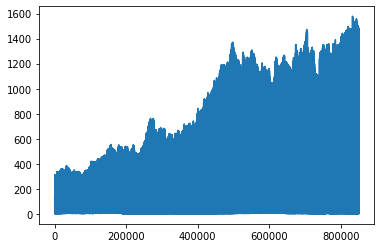

In [5]:
plt.plot(df1)

# Data preprocessing 

In [6]:
# scaling the dataset
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
df1 = sc.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
print(df1)

[[0.07881183]
 [0.07509483]
 [0.07190429]
 ...
 [0.03294556]
 [0.02782042]
 [0.03300899]]


In [8]:
#Splitting the data 
training_size= int(len(df1)*0.7)
test_size=len(df1)-training_size
train_data, test_data= df1[0:training_size,:],df1[training_size: len(df1), :1]

In [9]:
train_data.shape

(595884, 1)

In [10]:
training_size, test_size

(595884, 255380)

In [11]:
def creat_dataset(dataset, time_step=1):
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [12]:
import numpy
time_step = 100 
x_train, y_train = creat_dataset(train_data, time_step)
x_test, y_test = creat_dataset(test_data, time_step)

In [13]:
print(x_train.shape), print(y_train.shape)

(595783, 100)
(595783,)


(None, None)

In [14]:
print(x_test.shape), print(y_test.shape)

(255279, 100)
(255279,)


(None, None)

In [15]:
#reshape input to be [sample, time steps, features] which is required for LSTM
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

#Build the LSTM model

In [16]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [52]:
model = Sequential()
model.add(LSTM(50, return_sequences=True,input_shape=(100,1)))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer= 'adam')

In [55]:
model.fit(x_train, y_train, validation_data=(x_test,y_test),epochs=10, batch_size=256, verbose=1)

Epoch 1/10
2328/2328 [==============================] - 197s 85ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 2/10
2328/2328 [==============================] - 188s 81ms/step - loss: 0.0014 - val_loss: 0.0038
Epoch 3/10
2328/2328 [==============================] - 181s 78ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 4/10
2328/2328 [==============================] - 178s 77ms/step - loss: 9.0941e-04 - val_loss: 0.0021
Epoch 5/10
2328/2328 [==============================] - 176s 76ms/step - loss: 5.0575e-04 - val_loss: 0.0019
Epoch 6/10
2328/2328 [==============================] - 175s 75ms/step - loss: 3.7499e-04 - val_loss: 0.0018
Epoch 7/10
2328/2328 [==============================] - 175s 75ms/step - loss: 2.7912e-04 - val_loss: 0.0016
Epoch 8/10
2328/2328 [==============================] - 175s 75ms/step - loss: 2.1766e-04 - val_loss: 0.0017
Epoch 9/10
2328/2328 [==============================] - 175s 75ms/step - loss: 1.7976e-04 - val_loss: 0.0016
Epoch 10/10
2328/2328 [========

# Prediction 

In [56]:
# Prediction and check performance metrics
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [57]:
#Transformback to original form

train_predict=sc.inverse_transform(train_predict)
test_predict=sc.inverse_transform(test_predict)

In [58]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

78.96641075035288

In [59]:
#Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

104.13551346378104

# Plot the prediction 

<function matplotlib.pyplot.show>

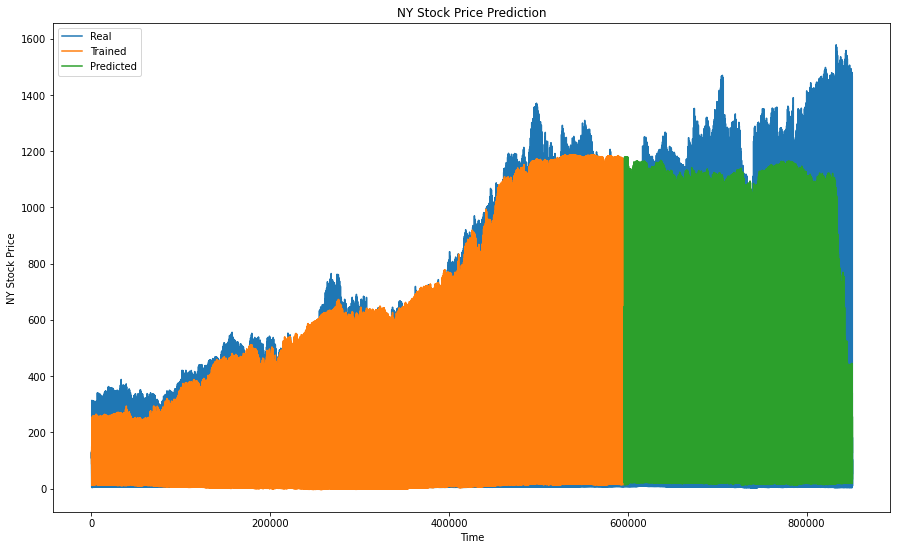

In [61]:

# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:,:]= np.nan
trainPredictPlot[look_back: len(train_predict)+look_back,:] = train_predict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:,:] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# Plet baseline and predictions 
plt.figure(figsize=(15, 9))
plt.plot(sc.inverse_transform(df1), label= 'Real')
plt.plot(trainPredictPlot, label= 'Trained')
plt.plot(testPredictPlot, label= 'Predicted')
plt.title('NY Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NY Stock Price')
plt.legend()
plt.show